In [ ]:
!pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 878.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
!pip install accelerate -U

In [ ]:
from datasets import load_dataset
from transformers import BertTokenizer, BertModel, DataCollatorWithPadding, get_linear_schedule_with_warmup, AdamW, BertForSequenceClassification, get_scheduler, TrainingArguments, Trainer
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import evaluate
import numpy as np
import matplotlib.pyplot as plt

# Data preprocessing

In [ ]:
dataset = load_dataset("glue", "stsb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})

### Visualize the distribution of the labels in train and validation dataset

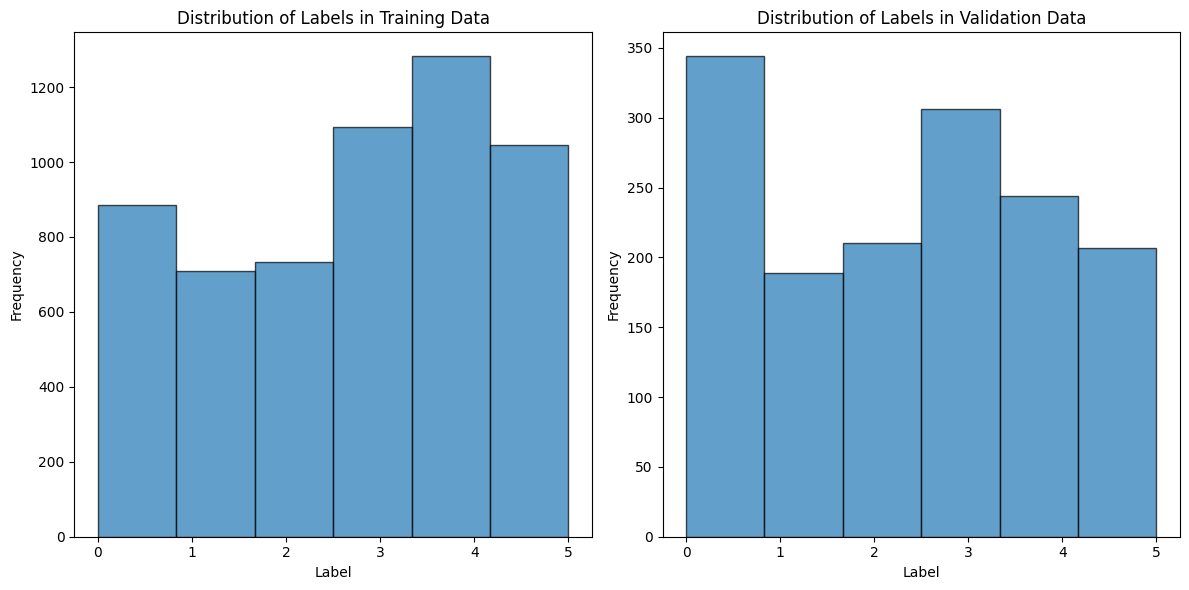

In [ ]:
# visualize the distribution of the labels

train_labels = dataset['train']['label']
validation_labels = dataset['validation']['label']

# Create histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=6, edgecolor='black', alpha=0.7)
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(validation_labels, bins=6, edgecolor='black', alpha=0.7)
plt.title('Distribution of Labels in Validation Data')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
model_id = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_id)

def tokenize_fun(example):
  # stardardize the label
  example['label'] = [e / 5.0 for e in example['label']]
  return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = dataset.map(tokenize_fun, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

## Prepare for training

In [ ]:
training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch")
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=1)

def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "stsb")
    logits, labels = eval_preds
    # predictions = np.argmax(logits, axis=-1)
    predictions = 1 / (1 + np.exp(-logits))
    # predictions = torch.sigmoid(logits)
    return metric.compute(predictions=predictions, references=labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,0.037700,0.031624,0.877498,0.875981
2,0.019500,0.029524,0.893265,0.889635
3,0.007700,0.018464,0.899758,0.895929


Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=2157, training_loss=0.01865365503007856, metrics={'train_runtime': 281.4566, 'train_samples_per_second': 61.278, 'train_steps_per_second': 7.664, 'total_flos': 469569364944990.0, 'train_loss': 0.01865365503007856, 'epoch': 3.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_name = f"{model_id}-finetuned"
output_dir = f'./drive/MyDrive/ml_class_group_project/Lili/final/{model_name}'

model.save_pretrained(output_dir)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.018464382737874985,
 'eval_pearson': 0.8997584011268217,
 'eval_spearmanr': 0.8959293897360453,
 'eval_runtime': 4.6258,
 'eval_samples_per_second': 324.269,
 'eval_steps_per_second': 40.642,
 'epoch': 3.0}